# Clasificador de Propinas para Viajes en Taxi en NYC (2020)

Inspirado en la charla ["Keeping up with Machine Learning in Production"](https://github.com/shreyashankar/debugging-ml-talk) de [Shreya Shankar](https://twitter.com/sh_reya)


Este notebook muestra la construcción de un modelo de machine learning de juguete, usando datos de viajes de los taxis amarillos de Nueva York para el año 2020, [proporcionados por la NYC Taxi and Limousine Commission (TLC)](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). 

La idea es encontrar aquellos viajes donde la propina dejada por el pasajero fue alta, es decir, mayor al 20% del costo del viaje.

Para ello ajustaremos un modelo de classificación binaria RandomForest usando los datos de los viajes de enero de 2020. Probaremos el modelo resultante sobre los datos de los viajes de febrero de 2020. Compararemos el desempeño del modelo en ambos casos usando la métrica de [f1-score](https://en.wikipedia.org/wiki/F-score).

**Este notebook está construido para ser ejecutado en [Google Colab](https://colab.research.google.com/), al que podemos acceder de manera gratuita solo teniendo un usuario de Google (Gmail) y un navegador web. No es necesario instalar nada en el computador local.**

## Cargando las librerías necesarias

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import joblib

## Leemos los datos de enero 2020 (entrenamiento)

In [2]:
taxi = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-01.parquet')

In [3]:
taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,None
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,None
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,None
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,None
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0,None


In [4]:
taxi.shape

(6405008, 19)

In [5]:
taxi['tpep_pickup_datetime'] = pd.to_datetime(taxi['tpep_pickup_datetime'])
taxi['tpep_dropoff_datetime'] = pd.to_datetime(taxi['tpep_dropoff_datetime'])

In [6]:
taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5,None
1,1,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5,None
2,1,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5,None
3,1,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0,None
4,2,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0,None


In [7]:
taxi.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

## Definimos las características con las que realizaremos la clasificación. 

Las construiremos a continuación en la etapa de pre-procesamiento de los datos.

In [5]:
numeric_feat = [
    "pickup_weekday",
    "pickup_hour",
    'work_hours',
    "pickup_minute",
    "passenger_count",
    'trip_distance',
    'trip_time',
    'trip_speed'
]
categorical_feat = [
    "PULocationID",
    "DOLocationID",
    "RatecodeID",
]
features = numeric_feat + categorical_feat
EPS = 1e-7

In [6]:
def preprocess(df, target_col):

   # Basic cleaning
    df = df[df['fare_amount'] > 0].reset_index(drop=True)  # avoid divide-by-zero
    # add target
    df['tip_fraction'] = df['tip_amount'] / df['fare_amount']
    df[target_col] = df['tip_fraction'] > 0.2

    # add features
    df['pickup_weekday'] = df['tpep_pickup_datetime'].dt.weekday
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
    df['pickup_minute'] = df['tpep_pickup_datetime'].dt.minute
    df['work_hours'] = (df['pickup_weekday'] >= 0) & (df['pickup_weekday'] <= 4) & (df['pickup_hour'] >= 8) & (df['pickup_hour'] <= 18)
    df['trip_time'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.seconds
    df['trip_speed'] = df['trip_distance'] / (df['trip_time'] + EPS)

    # drop unused columns
    df = df[['tpep_dropoff_datetime'] + features + [target_col]]
    df[features + [target_col]] = df[features + [target_col]].astype("float32").fillna(-1.0)

    # convert target to int32 for efficiency (it's just 0s and 1s)
    df[target_col] = df[target_col].astype("int32")

    return df.reset_index(drop=True)


In [7]:
target_col = "high_tip"

taxi_train = preprocess(df=taxi, target_col=target_col)

In [8]:
print(f'Num rows: {len(taxi_train)}, Size: {taxi_train.memory_usage(deep=True).sum() / 1e9} GB')

Num rows: 6382762, Size: 0.357434804 GB


## Ajustamos el modelo con los datos de entrenamiento

Este proceso se puede demorar bastante (¡en mi caso fueron 30 minutos!), pero podemos realizar una prueba mas pequeña reduciendo la cantidad de ejemplos de entrenamiento. Por ejemplo podríamos agregar la siguiente celda: 

`taxi_train = taxi_train.head(100000)`

In [9]:
%%time

rfc = RandomForestClassifier(n_estimators=100, max_depth=10)

rfc.fit(taxi_train[features], taxi_train[target_col])

KeyboardInterrupt: 

## Calculamos la métrica f1-score en el conjunto de entrenamiento

In [38]:
%%time
# Compute F1 

preds = rfc.predict_proba(taxi_train[features])

CPU times: user 1min, sys: 134 ms, total: 1min
Wall time: 1min 1s


In [40]:
preds_labels = [p[1] for p in preds.round()]

In [42]:
print(f'F1: {f1_score(taxi_train[target_col], preds_labels)}')

F1: 0.7296178114525199


## Exportamos el modelo a un archivo

In [13]:
import joblib

joblib.dump(rfc, "./random_forest.joblib")

['./random_forest.joblib']

El archivo aparecerá en el menú del lado izquierdo, como se muestra en la foto. Podemos guardarlo en nuestro equipo usando boton derecho -> Download. Será útil hacerlo porque lo seguiremos usando en el futuro.

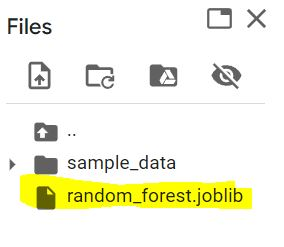

## Cargamos los datos de febrero 2020 (prueba)

In [10]:
taxi_feb = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-02.parquet')
taxi_test = preprocess(taxi_feb, target_col=target_col)
taxi_test.head()

,tpep_dropoff_datetime,pickup_weekday,pickup_hour,work_hours,pickup_minute,passenger_count,trip_distance,trip_time,trip_speed,PULocationID,DOLocationID,RatecodeID,high_tip
0,2020-02-01 00:30:32,5.0,0.0,0.0,17.0,1.0,2.60,777.0,0.003346,145.0,7.0,1.0,1
1,2020-02-01 01:05:36,5.0,0.0,0.0,32.0,1.0,4.80,1969.0,0.002438,45.0,61.0,1.0,1
2,2020-02-01 00:43:28,5.0,0.0,0.0,31.0,1.0,3.20,704.0,0.004545,186.0,140.0,1.0,0
3,2020-02-01 00:31:39,5.0,0.0,0.0,7.0,1.0,4.38,1444.0,0.003033,144.0,140.0,1.0,0
4,2020-02-01 01:01:29,5.0,0.0,0.0,51.0,1.0,2.28,586.0,0.003891,238.0,152.0,1.0,0


## Cargamos el modelo que guardamos y realizamos predicciones de prueba

In [29]:
loaded_rfc = joblib.load("./random_forest.joblib")

ModuleNotFoundError: No module named 'numpy._core'

In [18]:
%%time
# Compute F1 
# This is (relatively) slow since we are copying data to the CPU to compute the metric.

preds_test = loaded_rfc.predict_proba(taxi_test[features])

CPU times: total: 109 ms
Wall time: 164 ms


c:\Users\Víctor\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_forest.py:879: RuntimeWarning: invalid value encountered in divide
  proba /= len(self.estimators_)


In [19]:
preds_test_labels = [p[1] for p in preds_test.round()]
print(f'F1: {f1_score(taxi_test[target_col], preds_test_labels)}')

ValueError: Input y_pred contains NaN.

## Intentemos realizar la predicción de un solo viaje

Necesitaremos hacer algo así más adelante

In [51]:
taxi_test.head(1)[features].iloc[0].values

array([5.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.7000000e+01,
       1.0000000e+00, 2.5999999e+00, 7.7700000e+02, 3.3462034e-03,
       1.4500000e+02, 7.0000000e+00, 1.0000000e+00], dtype=float32)

In [56]:
taxi_test.head(1)[target_col].iloc[0]

1

In [54]:
loaded_rfc.predict_proba(taxi_test.head(1)[features].iloc[0].values.reshape(1, -1))[0][1]

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


0.5234936492710297

## Motivación: calculemos el desempeño para mayo de 2020

In [8]:
taxi_may= pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2020-04.parquet')


In [9]:
taxi_may.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2020-04-01 00:41:22,2020-04-01 01:01:53,1.0,1.20,1.0,N,41,24,2,5.5,0.5,0.5,0.00,0.0,0.3,6.80,0.0,None
1,1,2020-04-01 00:56:00,2020-04-01 01:09:25,1.0,3.40,1.0,N,95,197,1,12.5,0.5,0.5,2.75,0.0,0.3,16.55,0.0,None
2,1,2020-04-01 00:00:26,2020-04-01 00:09:25,1.0,2.80,1.0,N,237,137,1,10.0,3.0,0.5,1.00,0.0,0.3,14.80,2.5,None
3,1,2020-04-01 00:24:38,2020-04-01 00:34:38,0.0,2.60,1.0,N,68,142,1,10.0,3.0,0.5,1.00,0.0,0.3,14.80,2.5,None
4,2,2020-04-01 00:13:24,2020-04-01 00:18:26,1.0,1.44,1.0,Y,263,74,1,6.5,0.5,0.5,3.00,0.0,0.3,13.30,2.5,None


In [12]:
taxi_may.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [ ]:
taxi_test = preprocess(taxi_may, target_col=target_col)
taxi_test.head()

In [42]:
taxi_may['tpep_dropoff_datetime'] = pd.to_datetime(taxi_may['tpep_dropoff_datetime'])

In [ ]:
preds_test = loaded_rfc.predict_proba(taxi_test[features])
preds_test_labels = [p[1] for p in preds_test.round()]
print(f'F1: {f1_score(taxi_test[target_col], preds_test_labels)}')

# Medimos la diferencia estadistica de los conjuntos de datos de Febrero y Mayo (test-t)

In [30]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [47]:
taxi = taxi[['VendorID',
       'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge']]

taxi_may = taxi_may[['VendorID',
       'passenger_count', 'trip_distance', 'RatecodeID',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge']]

#### Como los conjuntos son muy grandes, extraemos una muestra aleatoria de 10.000 registros

In [54]:
muestra1 = taxi.sample(n=10000, random_state=1)
muestra2 = taxi_may.sample(n=10000, random_state=1)

In [55]:
muestra1.head()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
1989781,1,1.0,0.90,1.0,239,142,1,6.00,2.50,0.5,1.00,0.00,0.3,10.30,2.5
6355241,2,NaN,4.88,NaN,164,74,0,28.23,2.75,0.0,0.00,0.00,0.3,31.28,NaN
6234861,2,1.0,9.97,2.0,170,134,1,52.00,4.50,0.5,9.89,6.12,0.3,75.81,2.5
4320340,2,1.0,1.77,1.0,239,263,1,9.50,1.00,0.5,2.76,0.00,0.3,16.56,2.5
1847070,2,3.0,0.73,1.0,141,236,1,4.50,0.50,0.5,1.00,0.00,0.3,9.30,2.5


In [56]:
muestra1.fillna(0,inplace=True)
muestra1

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
1989781,1,1.0,0.90,1.0,239,142,1,6.00,2.50,0.5,1.00,0.00,0.3,10.30,2.5
6355241,2,0.0,4.88,0.0,164,74,0,28.23,2.75,0.0,0.00,0.00,0.3,31.28,0.0
6234861,2,1.0,9.97,2.0,170,134,1,52.00,4.50,0.5,9.89,6.12,0.3,75.81,2.5
4320340,2,1.0,1.77,1.0,239,263,1,9.50,1.00,0.5,2.76,0.00,0.3,16.56,2.5
1847070,2,3.0,0.73,1.0,141,236,1,4.50,0.50,0.5,1.00,0.00,0.3,9.30,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39178,2,1.0,1.71,1.0,249,79,1,9.00,0.50,0.5,2.56,0.00,0.3,15.36,2.5
2358927,2,1.0,0.89,1.0,164,230,1,5.00,0.00,0.5,1.66,0.00,0.3,9.96,2.5
120217,1,2.0,5.40,1.0,186,238,1,19.00,3.50,0.5,4.65,0.00,0.3,27.95,2.5
1994299,2,2.0,15.17,1.0,132,15,1,41.50,0.00,0.5,8.46,0.00,0.3,50.76,0.0


In [57]:
muestra2.fillna(0,inplace=True)
muestra2

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
133546,1,1.0,0.00,1.0,52,140,1,23.7,2.5,0.5,10.80,0.00,0.3,37.80,2.5
160463,2,1.0,5.72,1.0,107,24,1,23.5,0.0,0.5,5.36,0.00,0.3,32.16,2.5
50137,2,5.0,4.98,1.0,238,113,1,17.5,0.0,0.5,4.16,0.00,0.3,26.91,2.5
80103,1,1.0,0.00,1.0,235,39,1,57.2,0.0,0.5,0.00,6.12,0.3,64.12,0.0
49248,1,0.0,0.70,1.0,140,141,1,5.0,2.5,0.5,2.00,0.00,0.3,10.30,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76637,2,1.0,1.17,1.0,234,79,2,7.0,0.0,0.5,0.00,0.00,0.3,10.30,2.5
236463,2,0.0,7.58,0.0,208,159,0,23.9,0.0,0.0,4.84,0.00,0.3,29.04,0.0
212278,1,1.0,1.20,1.0,74,75,2,5.5,0.0,0.5,0.00,0.00,0.3,6.30,0.0
202068,1,1.0,4.20,1.0,193,137,2,13.5,2.5,0.5,0.00,0.00,0.3,16.80,2.5


In [58]:
# Prueba t de Student
t_stat, p_value = stats.ttest_ind(muestra1, muestra2)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: [13.49553117 21.13347731 -1.70368476  8.22393072 10.25609468 12.05483278
 -6.48320862  5.81641813  1.45253414  4.31915025 18.17838641  5.52700679
  3.42045329 10.93733038 33.24422042], P-value: [2.52046020e-041 4.62143830e-098 8.84555338e-002 2.08852959e-016
 1.27863882e-024 2.38719836e-033 9.18900126e-011 6.10383368e-009
 1.46368833e-001 1.57385610e-005 2.97807622e-073 3.29807067e-008
 6.26417578e-004 9.15935080e-028 6.33648336e-236]


#### Viendo solamente el p-value Vemos que se rechaza la hipotesis nula de que no hay una diferencia significativa entre las medias de las dos poblaciones